Welcome to QBusters submission to FLIQ Art track - Creating art with spooky action at a distance!

In [2]:
from helper import *
from qpixl import *
from QPIXL_qiskit.qpixl_parallel import decodeParallelQPIXL
from QPIXL_qiskit.qpixl_parallel import cFRQI as cFRQI_parallel
import qiskit
from qiskit import QuantumCircuit
from qiskit.visualization import *
from qiskit_aer import StatevectorSimulator
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
import os
from itertools import chain

import warnings
import soundfile
from playsound3 import playsound
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

backend = StatevectorSimulator(method="statevector")

from qiskit.circuit.library import QFT
from qiskit import transpile
from qiskit.circuit import Parameter
from qiskit.quantum_info import Statevector
import scipy


In this project we choose 2 main approaches to generate art based one entanglement : 1- Entangling images with Quantum Algorithms and 2- maximizing the Entanglement between two images. In both cases the QPIXL algorithm was used. This algorithm allows us to optimally compress and encode images into quantum circuits such that we can use non classical correlations to produce new art!

1- Entangling Images with Quantum Algorithms

In this section we utilize the QPIXL algorithm and entangle it with 2 algorithms: a Quantum Phase Estimation or a Variational Quantum Algorithm.

In [16]:
inter_cost=[]
inter_pics=[]


def cFRQI_with_alg_demo(a, compression, algo = 'None', params={}):
    """    Takes a standard image in a numpy array (so that the matrix looks like
    the image you want if you picture the pixels) and returns the QPIXL
    compressed FRQI circuit. The compression ratio determines
    how many gates will be filtered and then cancelled out. Made into code from this paper:
    https://www.nature.com/articles/s41598-022-11024-y

    Args:
        a (np.array): numpy array of image, must be flattened and padded with zeros up to a power of two
        compression (float): number between 0 an 100, where 0 is no compression and 100 is no image
        algo (string): string to choose which algorithm to use, eith VQA or QPE
        params (dic): dictionnary with parameters for each algorithm: 
            For VQA it takes 'p0'- the probability of measuring 0 that we wish to emulate on the encoding qubit and 'verbose' - wether the optimizer prints all the information or not
            For QPE it takes 'angle' - the angle to estimate  and 'algo_qubits' - the number of qubits for the Phase Estimation

    Returns:
        QuantumCircuit: qiskit circuit that prepared the encoded image

    """

    a = convertToAngles(a) # convert grayscale to angles
    a = preprocess_image(a) # need to flatten the transpose for easier decoding, 
                            # only really necessary if you want to recover an image.
                            # for classification tasks etc. transpose isn't required.
    n = len(a)
    k = ilog2(n)
    a = 2*a 
    a = sfwht(a)
    a = grayPermutation(a) 
    a_sort_ind = np.argsort(np.abs(a))
    # set smallest absolute values of a to zero according to compression param
    cutoff = int((compression / 100.0) * n)
    for it in a_sort_ind[:cutoff]:
        a[it] = 0

    if algo == 'VQA':
        global inter_cost
        global inter_pics

        inter_cost=[]

        inter_pics=[]

        # pylint: disable=missing-function-docstring
        verbose = params['verbose']
        p0 = params['p0']
        print("We consider only 1 qubit for the VQE")

        #np.random.seed(0)
        target_distr = {0: p0, 1: 1 - p0} #target distribution to emulate

        def cost_f(x): # cost function to minimize

            # Construct FRQI circuit
            dataqbits = qiskit.QuantumRegister(k,'storage qubits')
            encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
            algorithmqubit = qiskit.QuantumRegister(1,'algorithm qubits') #OPTIONAL 
                                    #additional qubit to do interesting stuff with 
            circuit = QuantumCircuit(algorithmqubit, dataqbits, encodingqubit)
            
            # Data qubits
            circuit.h(dataqbits)
            params = [x[0], x[1], x[2]]
            

            ctrl, pc, i = 0, 0, 0
            while i < (2**k):
                pc = int(0) # Reset the parity check
                if a[i] != 0:
                    
                    circuit.u(params[0], params[1], params[2], algorithmqubit[0])
                    circuit.cry(a[i],algorithmqubit[0],encodingqubit[0])  #normally would just be an ry gate 
                # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
                if i == ((2**k) - 1):
                    ctrl=0
                else:
                    ctrl = grayCode(i) ^ grayCode(i+1)
                    ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
                pc ^= (2**ctrl) # Update parity check
                i += 1
                while i < (2**k) and a[i] == 0:
                    # Compute control qubit
                    if i == ((2**k) - 1):
                        ctrl=0
                    else:
                        ctrl = grayCode(i) ^ grayCode(i+1)
                        ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
                    pc ^= (2**ctrl) # Update parity check
                    i += 1              
                for j in range(k):
                    if (pc >> j)  &  1:
                        circuit.cx(dataqbits[j], encodingqubit[0])

            circuit = circuit.reverse_bits()

            inter_pics.append(circuit) 

            probs = Statevector(circuit).probabilities([k+1]) #probability distribution of the algorithm qubit

            cost = (target_distr[0]-probs[0])**2 # cost

            if verbose:
                print('Target: ', print(target_distr))
                print('Params: ', params)
                print('Probs: ', probs)
                print('Cost: ', cost)
                print('---')
            inter_cost.append(cost)
            return cost
        

        result = scipy.optimize.minimize(cost_f, [np.random.rand()*np.pi/2,np.random.rand()*np.pi/2,np.random.rand()*np.pi/2], method='Nelder-Mead') #minimization of the cost function
        print(result)

        circuit=inter_pics[-1].reverse_bits()

    elif algo=='QPE':

        angle = params['angle'] #angle to estimate
        n_algo_qubits = params['algo_qubits'] #number of qubits for phase estimation

        # Construct FRQI circuit
        dataqbits = qiskit.QuantumRegister(k,'storage qubits')
        encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
        algorithmqubit = qiskit.QuantumRegister(n_algo_qubits,'algorithm qubits') #OPTIONAL 
                                #additional qubit to do interesting stuff with 
        circuit = QuantumCircuit(algorithmqubit,dataqbits, encodingqubit)
        
        # Data qubits and algorithm qubits
        circuit.h(dataqbits)

        circuit.h(algorithmqubit[:-1])
        circuit.x(algorithmqubit[-1])

        for i in range (n_algo_qubits-1):
            for _ in range(i+1):
                circuit.cp(angle, algorithmqubit[i], algorithmqubit[-1])

        circuit = circuit.compose(QFT(n_algo_qubits-1).inverse(), algorithmqubit[:-1]) #Inverse Fourier Transform

        ctrl, pc, i = 0, 0, 0
        jn =0
        while i < (2**k):
            pc = int(0) # Reset the parity check
            if a[i] != 0:
                #circuit.unitary(np.array([[np.cos(a[i]), -1j*np.sin(a[i])],
                                        #[-1j*np.sin(a[i]), np.cos(a[i])]]), algorithmqubit[0], label=f'alg_{i}')
                if jn >=n_algo_qubits-1:
                    jn=0

                circuit.cry(a[i],jn,encodingqubit)
                jn+=1  #normally would just be an ry gate 
            # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            pc ^= (2**ctrl) # Update parity check
            i += 1
            while i < (2**k) and a[i] == 0:
                # Compute control qubit
                if i == ((2**k) - 1):
                    ctrl=0
                else:
                    ctrl = grayCode(i) ^ grayCode(i+1)
                    ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
                pc ^= (2**ctrl) # Update parity check
                i += 1              
            for j in range(k):
                if (pc >> j)  &  1:
                    circuit.cx(dataqbits[j], encodingqubit[0])   

        circuit.x(algorithmqubit[-1])



    else:

        
        # Construct FRQI circuit
        dataqbits = qiskit.QuantumRegister(k,'storage qubits')
        encodingqubit = qiskit.QuantumRegister(1,'encoding qubit')
        algorithmqubit = qiskit.QuantumRegister(2,'algorithm qubits') #OPTIONAL 
                                #additional qubit to do interesting stuff with 
        circuit = QuantumCircuit(algorithmqubit,dataqbits, encodingqubit)
        
        # Data qubits
        circuit.h(dataqbits)
        circuit.h(algorithmqubit[0])

        ctrl, pc, i = 0, 0, 0
        while i < (2**k):
            pc = int(0) # Reset the parity check
            if a[i] != 0:
                circuit.unitary(np.array([[np.cos(a[i]), -1j*np.sin(a[i])],
                                        [-1j*np.sin(a[i]), np.cos(a[i])]]), algorithmqubit[0], label=f'alg_{i}')

                circuit.x(algorithmqubit[1])
                circuit.cry(a[i],algorithmqubit[0],encodingqubit)  #normally would just be an ry gate 
            # Loop over sequence of consecutive zero angles to cancel out CNOTS (or rather, to not include them)
            if i == ((2**k) - 1):
                ctrl=0
            else:
                ctrl = grayCode(i) ^ grayCode(i+1)
                ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
            pc ^= (2**ctrl) # Update parity check
            i += 1
            while i < (2**k) and a[i] == 0:
                # Compute control qubit
                if i == ((2**k) - 1):
                    ctrl=0
                else:
                    ctrl = grayCode(i) ^ grayCode(i+1)
                    ctrl = k - countr_zero(ctrl, n_bits=k+1) - 1
                pc ^= (2**ctrl) # Update parity check
                i += 1              
            for j in range(k):
                if (pc >> j)  &  1:
                    circuit.cx(dataqbits[j], encodingqubit[0])      
    circuit = circuit.reverse_bits()
    return circuit



As we can see in the circuit below we apply the QPIXL algorithm to encode an image and additiionally we can perform a quantum algorithm on extra qubits

In [17]:
circ = cFRQI_with_alg_demo(np.array([0,1,2,3,4,5,6,7]), 0,  params={})
circ.draw(fold=150,vertical_compression='high')

┌─────────┐  ┌───┐       ┌───────────┐  ┌───┐  ┌───┐┌──────────┐  ┌───┐  ┌───┐┌───────────┐┌───┐
    encoding qubit: ──────────────┤ Ry(π/2) ├──┤ X ├───────┤ Ry(-π/14) ├──┤ X ├──┤ X ├┤ Ry(-π/7) ├──┤ X ├──┤ X ├┤ Ry(-2π/7) ├┤ X ├
                    ┌───┐         └────┬────┘  └─┬─┘       └─────┬─────┘  └─┬─┘  └─┬─┘└────┬─────┘  └─┬─┘  └─┬─┘└─────┬─────┘└─┬─┘
  storage qubits_0: ┤ H ├──────────────┼─────────■───────────────┼──────────┼──────■───────┼──────────┼──────┼────────┼────────┼──
                    ├───┤              │                         │          │              │          │      │        │        │  
  storage qubits_1: ┤ H ├──────────────┼─────────────────────────┼──────────■──────────────┼──────────┼──────■────────┼────────┼──
                    ├───┤              │                         │                         │          │               │        │  
  storage qubits_2: ┤ H ├──────────────┼─────────────────────────┼─────────────────────────┼──────────■───────────────┼────────■──
                    ├───┤  ┌───┐       │       ┌───┐  ┌───┐      │                         │                          │           
algorithm qubits_0: ┤ X ├──┤ X ├───────┼───────┤ X ├──┤ X ├──────┼─────────────────────────┼──────────────────────────┼───────────
                    ├───┤┌─┴───┴─┐     │     ┌─┴───┴─┐└───┘      │      ┌───────┐          │      ┌───────┐           │           
algorithm qubits_1: ┤ H ├┤ alg_0 ├─────■─────┤ alg_1 ├───────────■──────┤ alg_3 ├──────────■──────┤ alg_7 ├───────────■───────────
                    └───┘└───────┘           └───────┘                  └───────┘                 └───────┘

We start with a fundamental Algorithm in the world of Quantum Computing - Quantum Phase Estimation! We use extra algorithm qubits to perform a phase estimation of a given angle. This algorithm uses the Quantum Fourier Transform to map a phase into the algorithm qubits. These algorithm qubits will entangle with QPIXL and controll the RY rotations used to encide the colors of a given image

AxesImage(size=(16, 8))


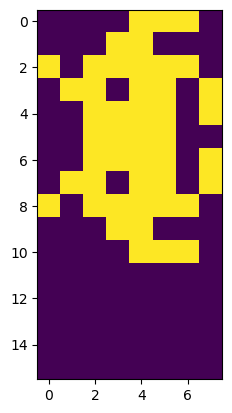

In [120]:
#As an Example ww start with an alien from Space Invaders
img = examples().space
print(plt.imshow(img))

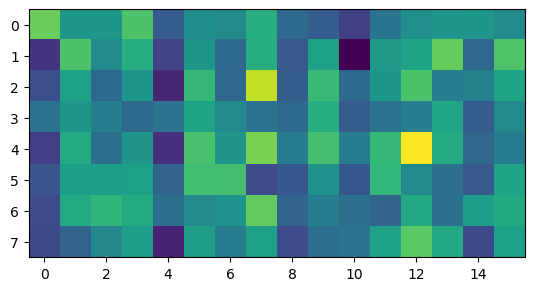

In [121]:
shape=img.shape
circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':3, 'angle':np.pi/3}) #We use 3 qubits for Estimation and an angle to estimate of pi/3. Other options can be chosen
job = backend.run(transpile(circ, backend))

#### Show the the image obtained from entangling the image with the Algorithm
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

We can freely change the number of algorithm qubits and the angle to estimate to obtain a different result

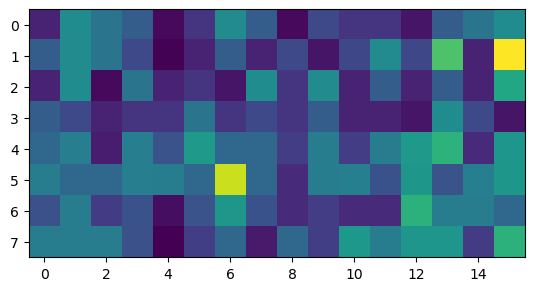

In [26]:
shape=img.shape
circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':5, 'angle':np.pi*2.789254362}) #We use 3 qubits for Estimation and an angle to estimate of 5pi/3. Other options can be chosen
job = backend.run(transpile(circ, backend))

#### Show the the image obtained from entangling the image with the Algorithm
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

Obviously we can also start with a different starting image. Images with strong symmetry give rise to interesting results!

AxesImage(size=(16, 16))


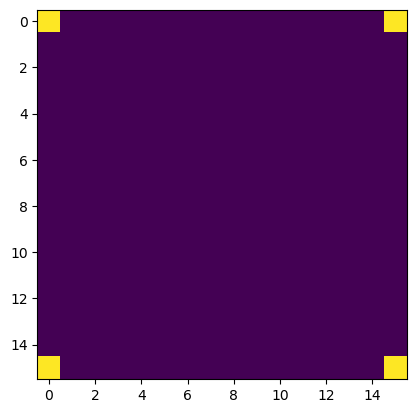

In [37]:
#img = examples().space
img=np.array([[ 0 for i in range(16)] for j in range(16)])

img[0][0]=1
img[0][-1]=1
img[-1][0]=1
img[-1][-1]=1

print(plt.imshow(img))

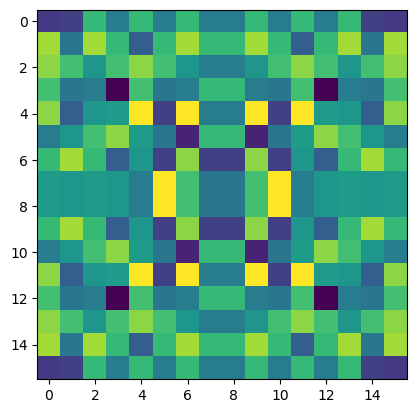

In [ ]:
shape=img.shape
circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':3, 'angle':8*np.pi/17}) #We use 3 qubits for Estimation and an angle to estimate of 8pi/17. Other options can be chosen
job = backend.run(transpile(circ, backend))

#### Show the the image obtained from entangling the image with the Algorithm
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

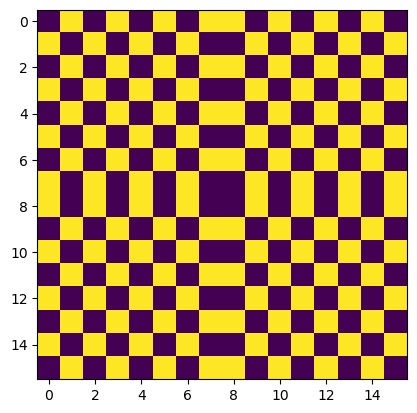

In [45]:
shape=img.shape
circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':3, 'angle':5*np.pi/7}) #We use 3 qubits for Estimation and an angle to estimate of 5pi/7. Other options can be chosen
job = backend.run(transpile(circ, backend))

#### Show the the image obtained from entangling the image with the Algorithm
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

We have no idea why this regular very  well formed image appeared :) (the angle and number of qubits was randomly chosen)! We can also import a more complicated image

(500, 475)
AxesImage(size=(32, 32))


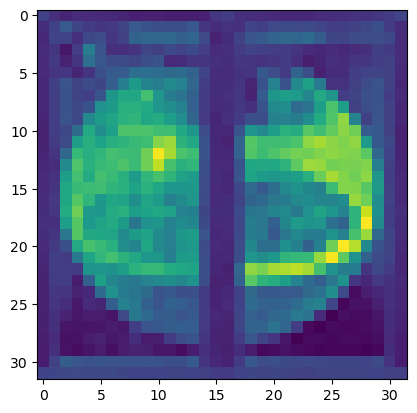

In [115]:
img = Image.open('figures/creation_world.png')
img = img.convert('L')
print(np.shape(img))
nsize=32
img = np.array(img.resize((nsize,nsize), Image.Resampling.LANCZOS))
print(plt.imshow(img))

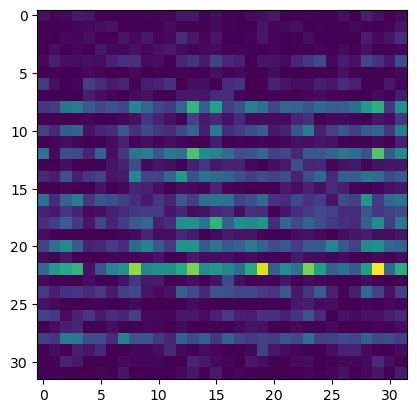

In [119]:
shape=(nsize,nsize)
circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':4, 'angle':17*np.pi/13}) #We use 4 qubits for Estimation and an angle to estimate of 5pi/7. Other options can be chosen
job = backend.run(transpile(circ, backend))

#### Show the the image obtained from entangling the image with the Algorithm
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape))

We can make an application to change the angle of the phase estimation wioth a slider and explore different images. Try it!

In [ ]:
def plot_interactive_QPE(ang):
    img = examples().space
    img = Image.open('figures/creation_world.png')
    img = img.convert('L')
    img = np.array(img.resize((nsize,nsize), Image.Resampling.LANCZOS))
    shape=(nsize,nsize)

    circ = cFRQI_with_alg_demo(img, 0, algo='QPE', params={'algo_qubits':3, 'angle':ang})
    job = backend.run(transpile(circ, backend))
    #### Just for show
    sv = np.real(job.result().get_statevector())
    imgt= decodeAngQPIXL(sv, circ,1)
    plt.imshow(reconstruct_img(imgt, shape))

interact(plot_interactive_QPE, ang=(-2*np.pi,2*np.pi,0.1))

interactive(children=(FloatSlider(value=-0.08318530717958605, description='ang', max=6.283185307179586, min=-6…

<function __main__.plot_interactive_QPE(ang)>

2- Variational Quantum Algorithm. For this second quantum algorithm we define a probability distribution of a single algorithm qubit that we want to emulate. We then use a classical machine to minimize a cost function obtained of the measurements of this specific qubit, such that the qubit change to the state that produces the desired distribution. This qubit is entangled with the encoding qubit which provides the entanglement between the algorithms.

In [156]:
#Once again we need a starting image

img = examples().space

We consider only 1 qubit for the VQE
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.801767717282415e-13
             x: [ 1.654e+00  9.626e-01  1.524e-01]
           nit: 110
          nfev: 202
 final_simplex: (array([[ 1.654e+00,  9.626e-01,  1.524e-01],
                       [ 1.654e+00,  9.626e-01,  1.524e-01],
                       [ 1.654e+00,  9.626e-01,  1.524e-01],
                       [ 1.654e+00,  9.626e-01,  1.524e-01]]), array([ 6.802e-13,  7.239e-13,  2.170e-12,  2.409e-12]))


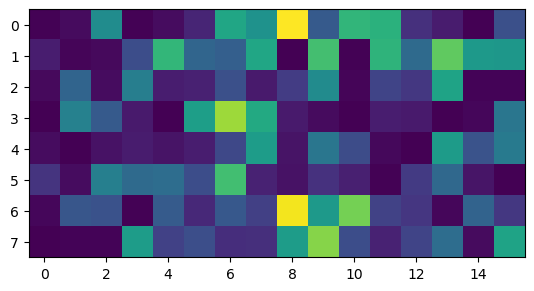

In [157]:
shape=img.shape

circ = cFRQI_with_alg_demo(img, 0, algo='VQA', params={'verbose':False, 'p0':0.27}) #We supress the prints of the minimizer by setting verbose to false and want the probability of the algorithm qubit to be in |09> to be 0.2
#circ.draw(fold=150,vertical_compression='high')
job = backend.run(transpile(circ, backend))
#### Just for show
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

Once again we use an image with strong symmetry

AxesImage(size=(16, 16))


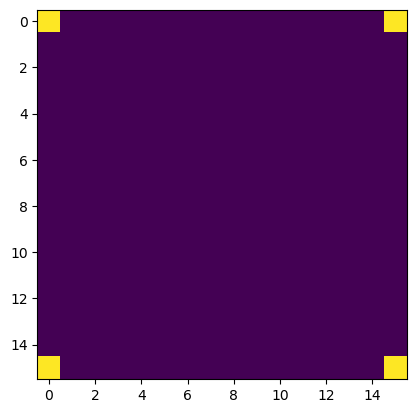

In [146]:
#Once again we need a starting image

#img = examples().space
img=np.array([[ 0 for i in range(16)] for j in range(16)])

img[0][0]=1
img[0][-1]=1
img[-1][0]=1
img[-1][-1]=1



print(plt.imshow(img))

We consider only 1 qubit for the VQE
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3.156803763624239e-16
             x: [ 8.634e-01  9.172e-02  4.981e-01]
           nit: 79
          nfev: 146
 final_simplex: (array([[ 8.634e-01,  9.172e-02,  4.981e-01],
                       [ 8.635e-01,  9.173e-02,  4.980e-01],
                       [ 8.634e-01,  9.172e-02,  4.981e-01],
                       [ 8.634e-01,  9.172e-02,  4.981e-01]]), array([ 3.157e-16,  3.861e-15,  5.919e-15,  2.770e-14]))


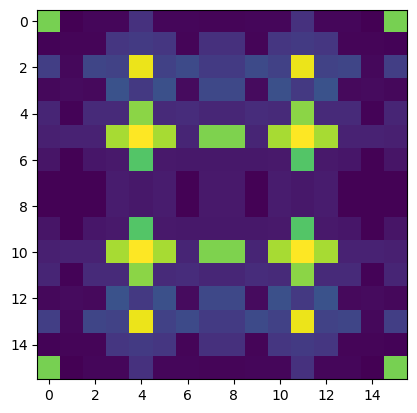

In [148]:
shape=img.shape

circ = cFRQI_with_alg_demo(img, 0, algo='VQA', params={'verbose':False, 'p0':0.3}) #We supress the prints of the minimizer by setting verbose to false and want the probability of the algorithm qubit to be in |09> to be 0.2
#circ.draw(fold=150,vertical_compression='high')
job = backend.run(transpile(circ, backend))
#### Just for show
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape).T)

(500, 475)
AxesImage(size=(32, 32))


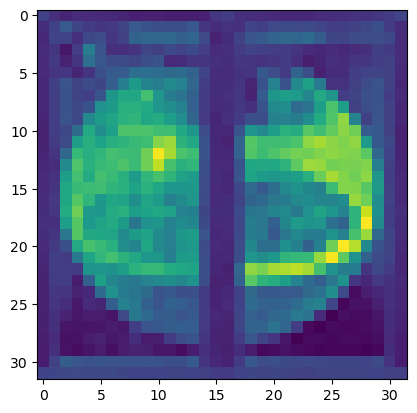

In [158]:
img = Image.open('figures/creation_world.png')
img = img.convert('L')
print(np.shape(img))
nsize=32
img = np.array(img.resize((nsize,nsize), Image.Resampling.LANCZOS))
print(plt.imshow(img))

We consider only 1 qubit for the VQE
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.502638435680572e-15
             x: [ 1.931e+00  7.766e+00 -5.386e+00]
           nit: 299
          nfev: 543
 final_simplex: (array([[ 1.931e+00,  7.766e+00, -5.386e+00],
                       [ 1.931e+00,  7.766e+00, -5.386e+00],
                       [ 1.931e+00,  7.766e+00, -5.386e+00],
                       [ 1.931e+00,  7.766e+00, -5.386e+00]]), array([ 8.503e-15,  1.103e-14,  1.179e-14,  2.711e-14]))


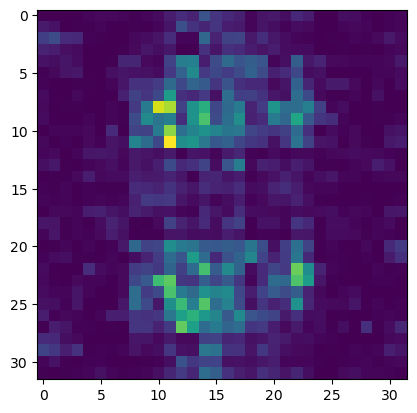

In [161]:
shape=(nsize,nsize)
circ = cFRQI_with_alg_demo(img, 0, algo='VQA', params={'verbose':False, 'p0':0.3}) #We supress the prints of the minimizer by setting verbose to false and want the probability of the algorithm qubit to be in |09> to be 0.2
#circ.draw(fold=150,vertical_compression='high')
job = backend.run(transpile(circ, backend))
#### Just for show
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape))

We also created an application to show the images formed during the minimization process - not only this generates cool art but it also helps to visualize a key  concept of a hybrid algorithm!

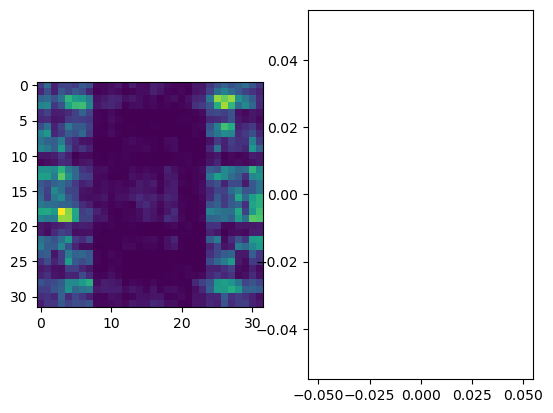

In [162]:
reconstructed_images = []
for i in range(len(inter_pics)):
    job = backend.run(transpile(inter_pics[i], backend))
    sv = np.real(job.result().get_statevector())
    imgt = decodeAngQPIXL(sv, circ, 1)
    img = reconstruct_img(imgt, shape)  # Transpose if needed for correct orientation
    reconstructed_images.append(img)

fig, (ax1, ax2) = plt.subplots(1,2)

# each frame

def fun_m(i):
    #plt.clf()
    im1 = ax1.imshow(reconstructed_images[i])
    im2 = ax2.plot(inter_cost[:i], color='Blue')
    plt.show()


ani = animation.FuncAnimation(fig, fun_m, interval=1, frames=len(reconstructed_images))
writergif =animation.PillowWriter(fps=5)
ani.save('VQA.gif', writer=writergif)
plt.show()

In the Gif on the left we can see the images, in the rigfht we can see the evolution of the cost funtion

AxesImage(size=(16, 16))


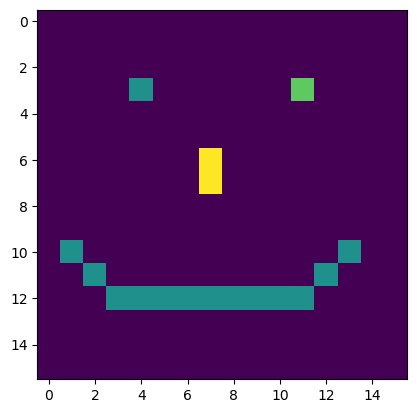

In [193]:
#Once again we need a starting image

#img = examples().space
img=np.array([[ 0 for i in range(16)] for j in range(16)])


img[3][4]=10
img[3][11]=15
img[7][7]=20
img[6][7]=20

img[10][13]=10
img[11][12]=10
img[12][11]=10
img[12][10]=10
img[12][9]=10
img[12][8]=10
img[12][7]=10
img[12][6]=10
img[12][5]=10
img[12][4]=10
img[12][3]=10
img[11][2]=10
img[10][1]=10



print(plt.imshow(img))

We consider only 1 qubit for the VQE
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.875362132380077e-12
             x: [ 1.561e+00  8.308e-01  4.456e-01]
           nit: 170
          nfev: 304
 final_simplex: (array([[ 1.561e+00,  8.308e-01,  4.456e-01],
                       [ 1.561e+00,  8.308e-01,  4.455e-01],
                       [ 1.561e+00,  8.307e-01,  4.457e-01],
                       [ 1.561e+00,  8.308e-01,  4.455e-01]]), array([ 4.875e-12,  5.522e-12,  3.997e-11,  5.347e-11]))


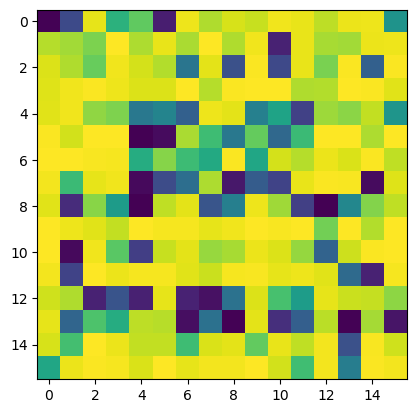

In [201]:
shape=img.shape

circ = cFRQI_with_alg_demo(img, 0, algo='VQA', params={'verbose':False, 'p0':0.27}) #We supress the prints of the minimizer by setting verbose to false and want the probability of the algorithm qubit to be in |09> to be 0.2
#circ.draw(fold=150,vertical_compression='high')
job = backend.run(transpile(circ, backend))
#### Just for show
sv = np.real(job.result().get_statevector())
imgt= decodeAngQPIXL(sv, circ,1)
plt.imshow(reconstruct_img(imgt, shape))

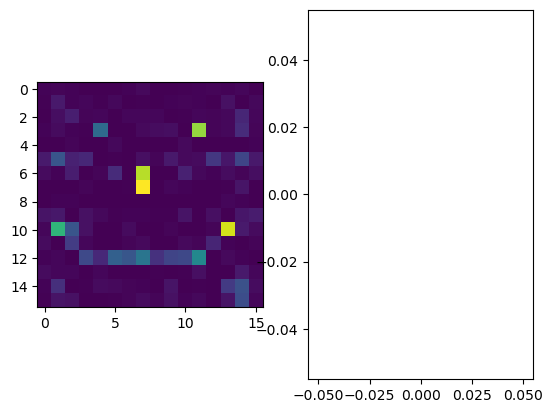

In [202]:
reconstructed_images = []
for i in range(len(inter_pics)):
    job = backend.run(transpile(inter_pics[i], backend))
    sv = np.real(job.result().get_statevector())
    imgt = decodeAngQPIXL(sv, circ, 1)
    img = reconstruct_img(imgt, shape)  # Transpose if needed for correct orientation
    reconstructed_images.append(img)

fig, (ax1, ax2) = plt.subplots(1,2)

# each frame

def fun_m(i):
    #plt.clf()
    im1 = ax1.imshow(reconstructed_images[i])
    im2 = ax2.plot(inter_cost[:i], color='Blue')
    plt.show()


ani = animation.FuncAnimation(fig, fun_m, interval=1, frames=len(reconstructed_images))
writergif =animation.PillowWriter(fps=5)
ani.save('VQA_2.gif', writer=writergif)
plt.show()